# Fitzhugh-Nagumo model

The Fitzhugh-Nagumo (FHN) model is a 2D simplification of the Hodgkin-Huxley model that retains some of the crucial features of more complicated neuron models. Its equations are given by:

$
v' = f(v,w) = v - \frac{v^3}{3} - w + I \\
w' = g(v,w) = \epsilon(b_0 + b_1 v - w)
$

where $v$ is the membrane voltage and $w$ is a recovery variable that models the slow dynamics observed in neurons.

The following function defines the _vector field_ of the model:

In [1]:
import numpy as np
fhn = lambda t,x,eps,b0,b1,I: np.array([
    x[0] - (x[0]**3)/3 - x[1] + I,
    eps*(b0 + b1*x[0] - x[1])
])

### Jacobian matrix

The Jacobian matrix of the FHN model is given by

$\frac{\partial f}{\partial v} = 1-v^2$

$\frac{\partial f}{\partial w} = -1$

$\frac{\partial g}{\partial v} = \epsilon b_1$

$\frac{\partial g}{\partial w} = -\epsilon$

We will use it to study the stability of the equilibria of the system.

In [2]:
fhn_jac = lambda t,x,eps,b0,b1,I: np.array([
    [1-x[0]**2, -1],
    [eps*b1, -eps]
])

### Nullclines

The nullclines of the system are the curves, in the $(v,w)$ plane, where the two ODEs making up the vector field are zero.

$
\dot{v}=0 \rightarrow w = v-\frac{v^3}{3}+I \\
\dot{w}=0 \rightarrow w = b_0+b_1v
$

The intersections of the nullclines are the points in the $(v,w)$ where both $\dot{v}=0$ and $\dot{w}=0$, i.e., the equilibria of the system.

In [3]:
# the nullclines
v_nullcline = lambda v,I: v - (v**3)/3 + I
w_nullcline = lambda v,b0,b1: b0 + b1*v
# the parameters of the system
eps = 0.1
b0, b1 = 0.9, 1
I = 0
# compute the nullclines
v_min,v_max = -2,2
v = np.linspace(v_min, v_max, 100)
v_null = v_nullcline(v, I)
w_null = w_nullcline(v, b0, b1)

# the vector field
w_min = min(v_null.min(),w_null.min())
w_max = max(v_null.max(),w_null.max())
V,W = np.meshgrid(np.linspace(v_min, v_max, 20), np.linspace(w_min, w_max, 20))
dVdt,dWdt = fhn(0, [V,W], eps, b0, b1, I)

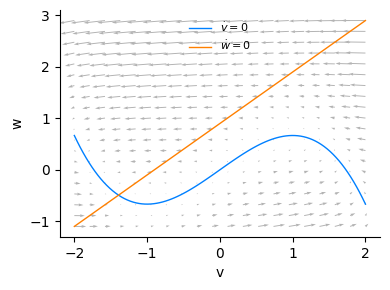

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(1, 1, figsize=(4,3))
ax.quiver(V, W, dVdt, dWdt, color=.7+np.zeros(3))
cmap = plt.get_cmap('viridis',3)
ax.plot(v, v_null, color=[0,.5,1], lw=1, label=r'$\dot{v}=0$')
ax.plot(v, w_null, color=[1,.5,0], lw=1, label=r'$\dot{w}=0$')
ax.legend(loc='best', frameon=False, fontsize=8)
ax.set_xlabel('v')
ax.set_ylabel('w')
fig.tight_layout()
sns.despine()

Show that as $I$ is varied, the v-nullcline moves up.

### Graphical analysis

The equilibria of the system are given by the intersection of the v-nullcline with the w-nullcline. We can find the $v$ coordinate by solving the 3rd-degree polynomial:

$-\frac{v^3}{3}+(1-b_1)v + (I-b_0) = 0$

while the $w$ coordinate can be obtained by plugging the value of $v$ into either nullcline.

In [5]:
def compute_equilibria(b0, b1, I):
    v_roots = np.roots([-1/3, 0, 1-b1, I-b0])
    equil = []
    for root in v_roots:
        if np.isreal(root):
            equil.append([root.real, v_nullcline(root.real, I)])
    equil = np.array(equil)
    return equil
equil = compute_equilibria(b0, b1, I)
n_equil = equil.shape[0]
print('For I={}, the system has {} equilibri{}.'.format(I, n_equil, 'um' if n_equil==1 else 'a'))

For I=0, the system has 1 equilibrium.


To evaluate the stability of the equilibria, we compute the eigenvalues of the Jacobian matrix at the equilibria: if all their real parts are negative, then the equilibrium is stable, otherwise it is unstable.

In [6]:
def compute_stability(equil):
    stable = np.zeros(equil.shape[0], dtype=bool)
    for i,eq in enumerate(equil):
        J = fhn_jac(0, eq, eps, b0, b1, I)
        eig,_ = np.linalg.eig(J)
        if all(list(map(lambda x: np.real(x)<0, eig))):
            stable[i] = True
    return stable
stable = compute_stability(equil)

Let's integrate the system starting from two different initial conditions:

In [7]:
from scipy.integrate import solve_ivp
tspan = [0,100]
sol = [
    solve_ivp(fhn, tspan, [-2,-0.5], method='BDF', jac=fhn_jac, args=(eps,b0,b1,I), rtol=1e-6, atol=1e-8),
    solve_ivp(fhn, tspan, [1,0], method='BDF', jac=fhn_jac, args=(eps,b0,b1,I), rtol=1e-6, atol=1e-8)
]

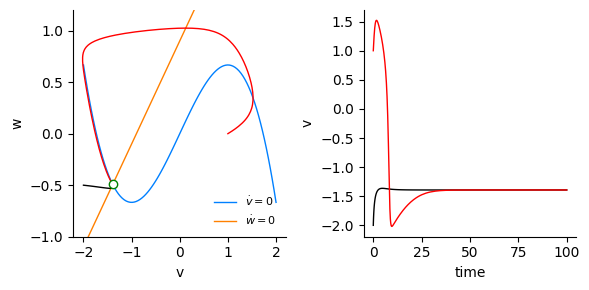

In [8]:
fig,ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(v, v_null, color=[0,.5,1], lw=1, label=r'$\dot{v}=0$')
ax[0].plot(v, w_null, color=[1,.5,0], lw=1, label=r'$\dot{w}=0$')
col = 'kr'
for i,xy in enumerate(sol):
    ax[0].plot(xy.y[0], xy.y[1], col[i], lw=1)
    ax[1].plot(xy.t, xy.y[0], col[i], lw=1)
for i,eq in enumerate(equil):
    col = 'g' if stable[i] else 'r'
    ax[0].plot(eq[0], eq[1], col+'o', markersize=6, markerfacecolor='w', markeredgewidth=1)
ax[0].legend(loc='best', frameon=False, fontsize=8)
ax[0].set_ylim([-1,1.2])
ax[0].set_xlabel('v')
ax[0].set_ylabel('w')
ax[1].set_xlabel('time')
ax[1].set_ylabel('v')
fig.tight_layout()
sns.despine()

The v-nullcline has two extrema at the points $(-1,I-2/3)$ and $(1,I+2/3)$.

It can be shown that an equilibrium located between these two points is unstable if $\epsilon$ is smaller than the slope of the v-nullcline at the equilibrium.

If the only equilibrium of the system is unstable, then the only possible solution is a limit cycle.

In [9]:
I = 1
v_null = v_nullcline(v, I)
w_null = w_nullcline(v, b0, b1)
equil = compute_equilibria(b0, b1, I)
stable = compute_stability(equil)
slope = 1-equil[0,0]**2
print('Slope of the v-nullcline at ({:.3f},{:.3f}): {:.3f}'.format(equil[0,0], equil[0,0], slope))
x0 = [-2,-0.5]
x0 = [1,1]
tspan = [0, 150]
sol = solve_ivp(fhn, tspan, x0, method='BDF', jac=fhn_jac, args=(eps,b0,b1,I), rtol=1e-6, atol=1e-8)

Slope of the v-nullcline at (0.669,0.669): 0.552


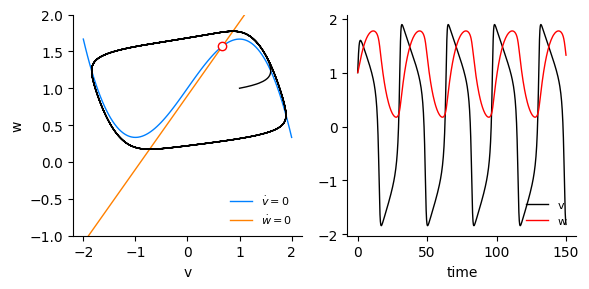

In [10]:
fig,ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(v, v_null, color=[0,.5,1], lw=1, label=r'$\dot{v}=0$')
ax[0].plot(v, w_null, color=[1,.5,0], lw=1, label=r'$\dot{w}=0$')
ax[0].plot(sol.y[0], sol.y[1], 'k', lw=1)
ax[1].plot(sol.t, sol.y[0], 'k', lw=1, label='v')
ax[1].plot(sol.t, sol.y[1], 'r', lw=1, label='w')
for i,eq in enumerate(equil):
    col = 'g' if stable[i] else 'r'
    ax[0].plot(eq[0], eq[1], col+'o', markersize=6, markerfacecolor='w', markeredgewidth=1)
for a in ax:
    a.legend(loc='lower right', frameon=False, fontsize=8)
ax[0].set_ylim([-1, 2])
ax[0].set_xlabel('v')
ax[0].set_ylabel('w')
ax[1].set_xlabel('time')
fig.tight_layout()
sns.despine()